<a href="https://colab.research.google.com/github/choderalab/gimlet/blob/master/lime/scripts/notebooks/190728_yuanqing_gn_with_gru_on_sereina_riniker_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GN on Sereina Riniker Dataset
yuanqing wang, jul 28, 2019


## Preparation

### Install gimlet

In [0]:
! pip install tensorflow==2.0.0-beta1
! pip uninstall gin-config -y
! rm -rf gimlet
! git clone https://github.com/choderalab/gimlet.git

     |████████████████████████████████| 87.9MB 38.8MB/s 
     |████████████████████████████████| 3.1MB 45.0MB/s 
     |████████████████████████████████| 501kB 45.7MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0
Uninstalling gin-config-0.2.0:
  Successfully uninstalled gin-config-0.2.0
Cloning into 'gimlet'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 1485 (delta 55), reused 66 (delta 30), pack-reused 1373
Receiving objects: 100% (1485/1485), 3.62 MiB | 1.10 MiB/s, done.
Resolving deltas: 100% (1044/1044), done.


In [0]:
import os
import sys
import tensorflow as tf
# import tensorflow_probability as tfp
# tf.enable_eager_execution()
sys.path.append('/content/gimlet')
import gin
import lime
import pandas as pd
import numpy as np

### Grab the dataset

In [0]:
! wget https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/230799/ChEMBL_eps_78.tar.gz
! tar -xzf *.tar.gz

--2019-07-29 03:21:42--  https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/230799/ChEMBL_eps_78.tar.gz
Resolving www.research-collection.ethz.ch (www.research-collection.ethz.ch)... 129.132.8.151
Connecting to www.research-collection.ethz.ch (www.research-collection.ethz.ch)|129.132.8.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32743757 (31M) [application/octet-stream]
Saving to: ‘ChEMBL_eps_78.tar.gz.1’

ChEMBL_eps_78.tar.g 100%[===================>]  31.23M  6.09MB/s    in 5.1s    

2019-07-29 03:21:49 (6.09 MB/s) - ‘ChEMBL_eps_78.tar.gz.1’ saved [32743757/32743757]



since there are way to many molecules, we select around a thousand molecules just to get our hands wet

In [0]:
! cat /content/ChEMBL_mols/*1.sdf > mols.sdf

### Preprocess

In [0]:
# read molecules into a tf.data.Dataset
ds_all = gin.i_o.from_sdf.to_ds('mols.sdf', has_charge=True)

W0729 03:22:03.211757 140114815813504 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:1340: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# by default, there is coordinates in dataset created from sdf
# now we get rid of it
ds_all = ds_all.map(lambda atoms, adjacency_map, coordinates, charges:\
    (atoms, adjacency_map, charges))

In [0]:
# put them in batches
ds_all = gin.probabilistic.gn.GraphNet.batch(ds_all, 256, per_atom_attr=True)

In [0]:
# get the number of samples
# NOTE: there is no way to get the number of samples in a dataset
# except loop through one time, unfortunately
n_batches = gin.probabilistic.gn.GraphNet.get_number_batches(ds_all)

W0729 03:22:06.073427 140113793476352 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0729 03:22:06.074082 140113785083648 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0729 03:22:06.120419 140113793476352 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0729 03:22:06.139481 140113785083648 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64
W0729 03:22:06.179470 140113793476352 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64


In [0]:
# now we split them into global test and the rest
n_global_te = int(0.2 * n_batches.numpy())
ds_tr = ds_all.skip(n_global_te)
ds_te = ds_all.take(n_global_te)

## Define a GN model

### Fix the dimensions of nodes, edges, and global attributes

In [0]:
# define the dimension of nodes, edges, and global attributes
D_V = 32
D_E = 32
D_U = 32

### Featurization of nodes, $f^v$

In [0]:
class f_v(tf.keras.Model):
    """ Featurization of nodes.
    Here we simply featurize atoms using one-hot encoding.
    
    """
    def __init__(self, units=D_V):
        super(f_v, self).__init__()
        self.d = tf.keras.layers.Dense(units)

    @tf.function
    def call(self, x):
        x = tf.one_hot(x, 8)
        # set shape because Dense doesn't like variation
        x.set_shape([None, 8]) 
        return self.d(x)

### Featurization of edges, $f^e$

The idea here is that we seperate the $\sigma$ and $\pi$ components of a bond and propagate information seperately.

In [0]:
class f_e(tf.keras.Model):
    """ Featurization of edges.
    Here we split the $\sigma$ and $\pi$ component of bonds
    into two channels, and featurize them seperately.
    
    """
    def __init__(
            self, 
            d_sigma_units=64, 
            d_pi_units=64,
            units=D_E):
        
        super(f_e, self).__init__()
        self.D_E = D_E
        
        # sigma
        self.d_sigma_0 = tf.Variable(
            tf.zeros(
                shape=(1, d_sigma_units),
                dtype=tf.float32))
        self.d_sigma_1 = tf.keras.layers.Dense(
            int(D_E // 2))
        
        # pi
        self.d_pi_0 = tf.keras.layers.Dense(
            d_pi_units)
        self.d_pi_1 = tf.keras.layers.Dense(
            int(D_E // 2))
        
    @tf.function
    def call(self, x):
        # determine whether there is $\pi$ component in the bond
        has_pi = tf.greater(
            x,
            tf.constant(1, dtype=tf.float32))
        
        # calculate the sigma component of the bond
        x_sigma = tf.tile(
            self.d_sigma_1(self.d_sigma_0),
            [tf.shape(x, tf.int64)[0], 1])
        
        # calculate the pi component of the bond
        x_pi = tf.where(
            has_pi,
            
            # if has pi:
            self.d_pi_1(
                self.d_pi_0(
                    tf.math.subtract(
                        x,
                        tf.constant(1, dtype=tf.float32)))),
            
            # else:
            tf.zeros(
                shape=(D_E // 2, ),
                dtype=tf.float32))
        
        
        x = tf.concat(
            [
                x_sigma,
                x_pi
            ],
            axis=1)
        
        
        return x
        
        

### Featurization of global attributes, $f^u$

In [0]:
f_u=(lambda atoms, adjacency_map, batched_attr_mask: \
    tf.tile(
        tf.zeros((1, D_U)),
        [
             tf.math.count_nonzero(
                 tf.reduce_any(
                     batched_attr_mask,
                     axis=0)),
             1
        ]
    ))

### Update of nodes, $\phi^v$

In [0]:
phi_v = lime.nets.for_gn.ConcatenateThenFullyConnect(
    (64, 'elu', 64, D_V))

### Update of edges, $\phi^e$

In [0]:
phi_e = lime.nets.for_gn.ConcatenateThenFullyConnect(
    (64, 'elu', 64, D_E))

### Update of global attributes, $\phi^u$

In [0]:
class phi_u(tf.keras.Model):
    def __init__(self, config=(64, 'elu', D_U)):
        super(phi_u, self).__init__()
        self.d = lime.nets.for_gn.ConcatenateThenFullyConnect(config)

    @tf.function
    def call(self, h_u, h_u_0, h_e_bar, h_v_bar):
        return self.d(h_u, h_u_0, h_e_bar, h_v_bar)

here the aggregation function are all just sum

### Readout function, $f_r$


Finally, we define the readout function, $f_r$, which is applied after all rounds of propagation. 

To deal with the problem that it is not trivial to directly predict the charge with constraint--charges being summed up to a constant that could be positive, negative, or zero, we optimize the model to predict hardness $s$ and electronegativity$e$, and then calculate the charge by minimizing the second-order Taylor expansion of the contribution of potential energy from charges. We use Lagrange multipliers to analytically give the solution.
        
\begin{align}
        U({\bf q})
        &= \sum_{i=1}^N \left[ e_i q_i +  \frac{1}{2}  s_i q_i^2\right]
            - \lambda \, \left( \sum_{j=1}^N q_j - Q \right) \\
        &= \sum_{i=1}^N \left[
            (e_i - \lambda) q_i +  \frac{1}{2}  s_i q_i^2 \right
            ] + Q
\end{align}

This gives us:

\begin{align}
        q_i^*
        &= - e_i s_i^{-1}
        + \lambda s_i^{-1} \\
        &= - e_i s_i^{-1}
        + s_i^{-1} \frac{
            Q +
             \sum\limits_{i=1}^N e_i \, s_i^{-1}
            }{\sum\limits_{j=1}^N s_j^{-1}}
\end{align}

        


Firstly, we define a function to analytically give us this solution.

In [0]:
@tf.function
def get_charges(e, s, Q):
    """ Solve the function to get the absolute charges of atoms in a
    molecule from parameters.

    Parameters
    ----------
    e : tf.Tensor, dtype = tf.float32, shape = (34, ),
        electronegativity.
    s : tf.Tensor, dtype = tf.float32, shape = (34, ),
        hardness.
    Q : tf.Tensor, dtype = tf.float32, shape=(),
        total charge of a molecule.

    We use Lagrange multipliers to analytically give the solution.

    $$

    U({\bf q})
    &= \sum_{i=1}^N \left[ e_i q_i +  \frac{1}{2}  s_i q_i^2\right]
        - \lambda \, \left( \sum_{j=1}^N q_j - Q \right) \\
    &= \sum_{i=1}^N \left[
        (e_i - \lambda) q_i +  \frac{1}{2}  s_i q_i^2 \right
        ] + Q

    $$

    This gives us:

    $$

    q_i^*
    &= - e_i s_i^{-1}
    + \lambda s_i^{-1} \\
    &= - e_i s_i^{-1}
    + s_i^{-1} \frac{
        Q +
         \sum\limits_{i=1}^N e_i \, s_i^{-1}
        }{\sum\limits_{j=1}^N s_j^{-1}}

    $$

    """

    return tf.math.add(
        tf.math.multiply(
            tf.math.negative(
                e),
            tf.math.pow(
                s,
                -1)),
        
        tf.math.multiply(
            tf.math.pow(
                s,
                -1),
            tf.math.divide(
                tf.math.add(
                    Q,
                    tf.reduce_sum(
                        tf.math.multiply(
                            e,
                            tf.math.pow(
                                s,
                                -1)))),
                tf.reduce_sum(
                    tf.math.pow(
                        s,
                        -1)))))

One thing worth noting is that, here in each batch we have many molecules, with sum function, we need to seperate them.

In [0]:
@tf.function
def get_q_i_hat_total_per_mol(e, s, Qs, attr_in_mol):
    """ Calculate the charges per molecule based on 
    `attr_in_mol`.
    
    """
    attr_in_mol.set_shape([None, None])
    
    attr_in_mol = tf.boolean_mask(
        attr_in_mol,
        tf.reduce_any(
            attr_in_mol,
            axis=1),
        axis=0)

    attr_in_mol = tf.boolean_mask(
        attr_in_mol,
        tf.reduce_any(
            attr_in_mol,
            axis=0),
    axis=1)

    q_i = tf.tile(
        tf.expand_dims(
            tf.constant(
                0,
                dtype=tf.float32),
            0),
        [tf.shape(attr_in_mol, tf.int64)[0]])
    
    def loop_body(q_i, idx, 
            e=e, 
            s=s, 
            Qs=Qs, 
            attr_in_mol=attr_in_mol):
        
        # get attr
        _attr_in_mol = attr_in_mol[:, idx]
        
        # get the attributes of each molecule
        _Qs = Qs[idx]
        
        _e = tf.boolean_mask(
            e,
            _attr_in_mol)
        
        _s = tf.boolean_mask(
            s,
            _attr_in_mol)
        
        _idxs = tf.where(_attr_in_mol)
        
        # update
        q_i = tf.tensor_scatter_nd_update(
            q_i,
        
            # idxs
            _idxs,
        
            # update
            tf.reshape(
                    get_charges(
                        _e,
                        _s,
                        _Qs),
                [-1]))
        
        return q_i, tf.add(idx, tf.constant(1, dtype=tf.int64))
    
    idx = tf.constant(0, dtype=tf.int64)
    
    # loop_body(q_i, idx)
    
    
    q_i, idx = tf.while_loop(
        lambda _, idx: tf.less(
            idx,
            tf.shape(attr_in_mol, tf.int64)[1]),
    
        loop_body,
        
        [q_i, idx])
    
    
    return q_i
         
    

We define the readout function accordingly.

In [0]:
class f_r(tf.keras.Model):
    """ Readout function.
    """
    
    def __init__(self, units=128):
        super(f_r, self).__init__()
        self.d_e_0 = tf.keras.layers.Dense(units)
        self.d_s_0 = tf.keras.layers.Dense(units)
        self.d_e_1 = tf.keras.layers.Dense(1)
        self.d_s_1 = tf.keras.layers.Dense(1)
    
    @tf.function
    def call(self,
            h_e, h_v, h_u,
            h_e_history, h_v_history, h_u_history,
            atom_in_mol, bond_in_mol):
        
        # although this could take many many arguments,
        # we only take $h_e$ for now
        e = self.d_e_1(self.d_e_0(h_v))
        s = self.d_s_1(self.d_s_0(h_v))
        
        return e, s
        
        

### Put everything together to define a complete graph net.

In [0]:
gn = gin.probabilistic.gn.GraphNet(
    f_e=f_e(),
    f_v=f_v(),
    f_u=f_u,
    phi_e=phi_e,
    phi_v=phi_v,
    phi_u=phi_u(),
    f_r=f_r())

## Training

### Define optimizer and number of epochs

In [0]:
optimizer = tf.keras.optimizers.Adam(1e-4)
N_EPOCHS = 10

### Helper function to calculate per-molecule total charge

In [0]:
@tf.function
def get_q_total_per_mol(q_i, attr_in_mol):
    # attr_in_mol.set_shape([None, None])
    
    q_i = tf.boolean_mask(
        q_i,
        tf.reduce_any(
            attr_in_mol,
            axis=1))
    
    attr_in_mol = tf.boolean_mask(
        attr_in_mol,
        tf.reduce_any(
            attr_in_mol,
            axis=1),
        axis=0)

    attr_in_mol = tf.boolean_mask(
        attr_in_mol,
        tf.reduce_any(
            attr_in_mol,
            axis=0),
    axis=1)
    
    attr_in_mol = tf.where(
        attr_in_mol,
    
        tf.ones_like(
            attr_in_mol,
            dtype=tf.float32),
    
        tf.zeros_like(
            attr_in_mol,
            dtype=tf.float32))
    
    q_per_mol = tf.reduce_sum(
        tf.multiply(
            attr_in_mol,
            tf.tile(
                tf.expand_dims(
                        q_i,
                        1),
                [
                    1,
                    tf.shape(attr_in_mol, tf.int64)[1]
                ])),
        axis=0)
    
    return q_per_mol
    
    

### start training

In [0]:
# @tf.function
def train():
    losses = tf.constant([-1], dtype=tf.float32)
    for dummy_idx in range(N_EPOCHS):
        for atoms, adjacency_map, atom_in_mol, bond_in_mol, q_i, attr_in_mol \
            in ds_tr:
            with tf.GradientTape() as tape:
                Qs = get_q_total_per_mol(q_i, attr_in_mol)
                
                e, s = gn(
                    atoms, adjacency_map, atom_in_mol, bond_in_mol, attr_in_mol)
                
                e = tf.boolean_mask(
                    e,
                    tf.reduce_any(
                        attr_in_mol,
                        axis=1))

                s = tf.boolean_mask(
                    s,
                    tf.reduce_any(
                        attr_in_mol,
                        axis=1))

                q_i_hat = get_q_i_hat_total_per_mol(
                                    e, s, Qs, attr_in_mol)
                
                q_i = tf.boolean_mask(
                    q_i,
                    tf.reduce_any(
                        attr_in_mol,
                        axis=1))
                
                loss = tf.losses.mean_squared_error(
                    q_i,
                    q_i_hat)

            variables = gn.variables
            grad = tape.gradient(loss, variables)
            optimizer.apply_gradients(
                zip(grad, variables))

            losses = tf.concat([
                losses,
                [loss],

            ],
            axis=0)
            
    return losses, gn

losses, gn = train()

In [0]:
losses = losses[1:]

## Inspect Learning Curve

In [0]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'MSE')

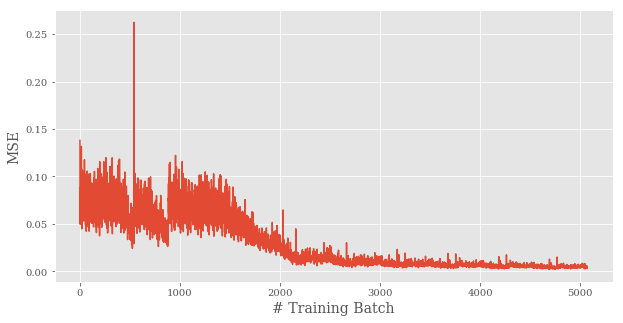

In [0]:
plt.style.use('ggplot')
plt.rc('font', family='serif')


plt.figure(figsize=(10, 5))
plt.plot(losses.numpy())
plt.xlabel('# Training Batch', fontsize=14)
plt.ylabel('MSE', fontsize=14)

### Test on Training Set

In [0]:
q_i_true = tf.constant([-1], dtype=tf.float32)
q_i_pred = tf.constant([-1], dtype=tf.float32)

for atoms, adjacency_map, atom_in_mol, bond_in_mol, q_i, attr_in_mol \
    in ds_tr:

    Qs = get_q_total_per_mol(q_i, attr_in_mol)
    e, s = gn(
        atoms, adjacency_map, atom_in_mol, bond_in_mol, attr_in_mol)
    e = tf.boolean_mask(
        e,
        tf.reduce_any(
            attr_in_mol,
            axis=1))

    s = tf.boolean_mask(
        s,
        tf.reduce_any(
            attr_in_mol,
            axis=1))

    q_i_hat = get_q_i_hat_total_per_mol(
                        e, s, Qs, attr_in_mol)

    q_i = tf.boolean_mask(
        q_i,
        tf.reduce_any(
            attr_in_mol,
            axis=1))

    q_i_true = tf.concat(
        [
            q_i_true,
            q_i
        ],
        axis=0)

    q_i_pred = tf.concat(
        [
            q_i_pred,
            q_i_hat
        ],
        axis=0)



In [0]:
q_i_true = q_i_true[1:]
q_i_pred = q_i_pred[1:]

Text(0.5, 1.0, 'Predicted Charges on Training Set')

<Figure size 2880x2880 with 0 Axes>

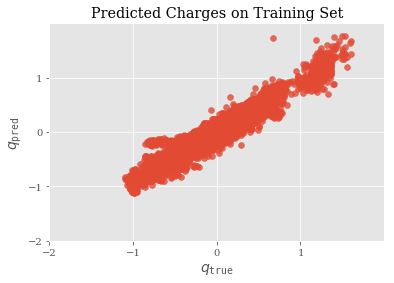

In [0]:
plt.figure(figsize=(40, 40))
fig, ax = plt.subplots()

ax.set_xlim([-2.0, 2.0])
ax.set_ylim([-2.0, 2.0])

ax.scatter(
    q_i_true.numpy(),
    q_i_pred.numpy(),
    alpha=0.8)

ax.tick_params(labelsize=10)
ax.set_xticks(np.arange(-2.0, 2.0, 1))
ax.set_yticks(np.arange(-2.0, 2.0, 1))
ax.set_xlabel('$q_\mathtt{true}$', fontsize=14)
ax.set_ylabel('$q_\mathtt{pred}$', fontsize=14)
ax.set_title('Predicted Charges on Training Set')

In [0]:
print("MSE on training set is %s " % tf.losses.mean_squared_error(
    q_i_true,
    q_i_pred).numpy())

MSE on training set is 0.004874341 


In [0]:
from sklearn import *
print("$R^2$ on training set is %s " % metrics.r2_score(
    q_i_true,
    q_i_pred))

$R^2$ on training set is 0.9375542641732115 


In [0]:
import scipy
print('Pearson R on training set is %s ' % scipy.stats.pearsonr(q_i_true, q_i_pred)[0])

Pearson R on training set is 0.9683551843312522 


In [0]:
print('Spearman R on training set is %s ' % scipy.stats.spearmanr(
    q_i_true, q_i_pred)[0])

Spearman R on training set is 0.9154855342847189 


### Test on test set

In [0]:
q_i_true = tf.constant([-1], dtype=tf.float32)
q_i_pred = tf.constant([-1], dtype=tf.float32)

for atoms, adjacency_map, atom_in_mol, bond_in_mol, q_i, attr_in_mol \
    in ds_te:

    Qs = get_q_total_per_mol(q_i, attr_in_mol)
    e, s = gn(
        atoms, adjacency_map, atom_in_mol, bond_in_mol, attr_in_mol)
    e = tf.boolean_mask(
        e,
        tf.reduce_any(
            attr_in_mol,
            axis=1))

    s = tf.boolean_mask(
        s,
        tf.reduce_any(
            attr_in_mol,
            axis=1))

    q_i_hat = get_q_i_hat_total_per_mol(
                        e, s, Qs, attr_in_mol)

    q_i = tf.boolean_mask(
        q_i,
        tf.reduce_any(
            attr_in_mol,
            axis=1))

    q_i_true = tf.concat(
        [
            q_i_true,
            q_i
        ],
        axis=0)

    q_i_pred = tf.concat(
        [
            q_i_pred,
            q_i_hat
        ],
        axis=0)




In [0]:
q_i_true = q_i_true[1:]
q_i_pred = q_i_pred[1:]

Text(0.5, 1.0, 'Predicted Charges on Test Set')

<Figure size 2880x2880 with 0 Axes>

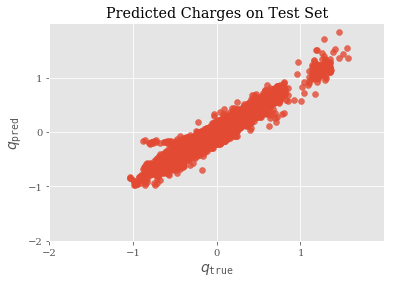

In [0]:
plt.figure(figsize=(40, 40))
fig, ax = plt.subplots()

ax.set_xlim([-2.0, 2.0])
ax.set_ylim([-2.0, 2.0])

ax.scatter(
    q_i_true.numpy(),
    q_i_pred.numpy(),
    alpha=0.8)

ax.tick_params(labelsize=10)
ax.set_xticks(np.arange(-2.0, 2.0, 1))
ax.set_yticks(np.arange(-2.0, 2.0, 1))
ax.set_xlabel('$q_\mathtt{true}$', fontsize=14)
ax.set_ylabel('$q_\mathtt{pred}$', fontsize=14)
ax.set_title('Predicted Charges on Test Set')

In [0]:
print("MSE on test set is %s " % tf.losses.mean_squared_error(
    q_i_true,
    q_i_pred).numpy())

MSE on test set is 0.006685592 


In [0]:
from sklearn import *
print("$R^2$ on test set is %s " % metrics.r2_score(
    q_i_true,
    q_i_pred))

$R^2$ on test set is 0.9124353801798808 


In [0]:
import scipy
print('Pearson R on test set is %s ' % scipy.stats.pearsonr(q_i_true, q_i_pred)[0])

Pearson R on test set is 0.9569017357114656 


In [0]:
print('Spearman R on test set is %s ' % scipy.stats.spearmanr(
    q_i_true, q_i_pred)[0])

Spearman R on test set is 0.9164685068765558 
